In [1]:
import os
import sys
# Add src/ to sys.path (relative to current notebook)
sys.path.append(os.path.abspath("../../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import mlflow

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from utils.VariableAnalysis import UnivariateAnalysis,BivariateAnalysis

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
file_path = pathlib.Path('D:\Capstone Project\dataset\House_Price_dataset')
df = pd.read_csv(f"{file_path}/9.gurgao_properties_post_feature_selection.csv")
df.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,36.0,3,2,2.0,1.0,850.0,0,0,0,1.0,1.0,0.82
1,0.0,95.0,2,2,2.0,1.0,1226.0,1,0,0,1.0,2.0,0.95
2,0.0,103.0,2,2,1.0,1.0,1000.0,0,0,0,1.0,0.0,0.32
3,0.0,99.0,3,4,4.0,3.0,1615.0,1,0,1,0.0,2.0,1.60
4,0.0,5.0,2,2,1.0,3.0,582.0,0,1,0,0.0,2.0,0.48


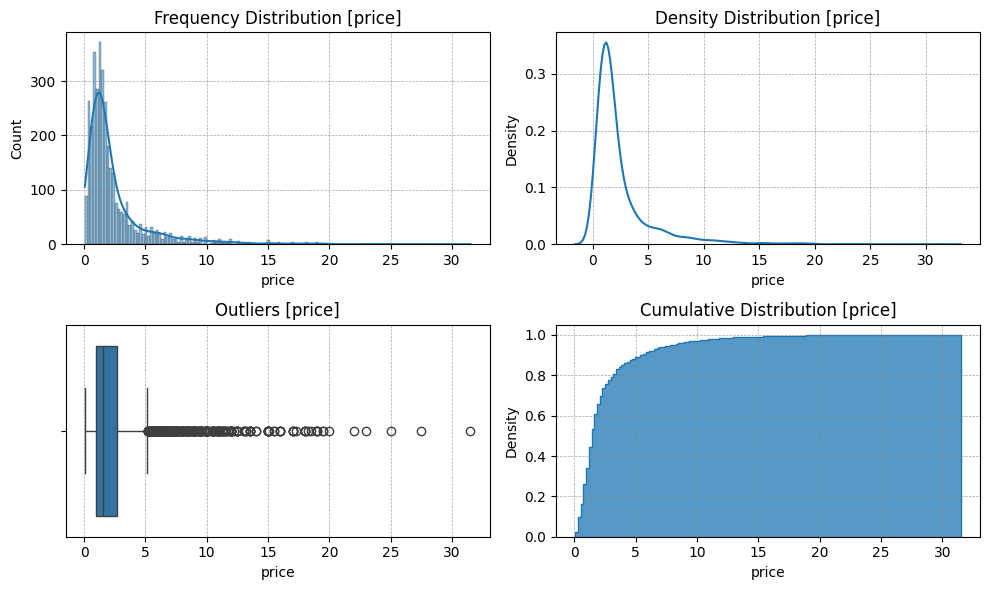

In [3]:
## Price Column Deep Analysis, price column is right skewed 
df_uni = UnivariateAnalysis(df)
a,b= df_uni.NumericalFeatureAnalysis('price')

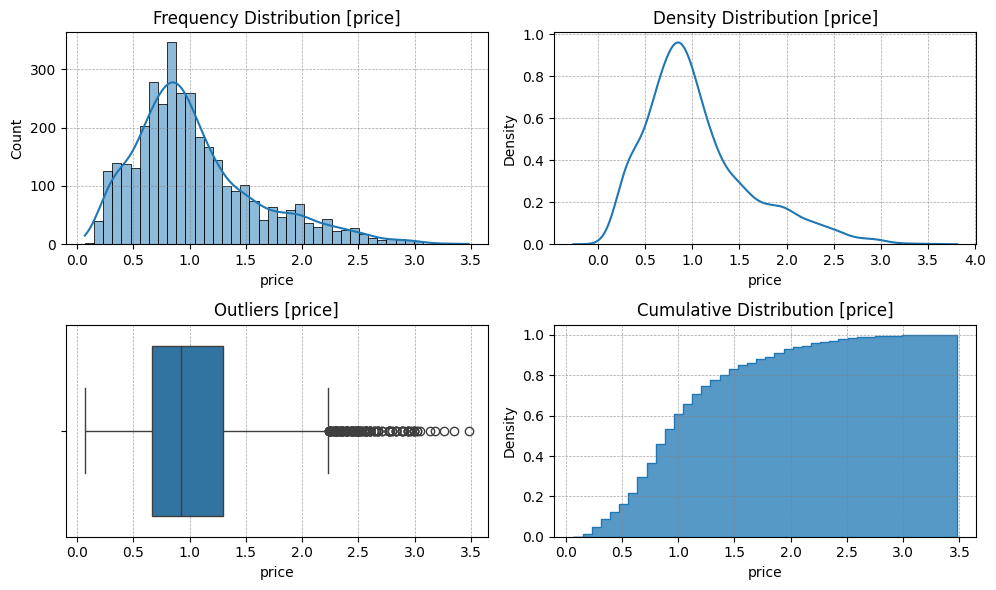

In [4]:
## Since price column is right skewed, log normal tranformation is applied

df['price'] = np.log1p(df['price'])

df_uni =  UnivariateAnalysis(df)
log_transfored_Observation, log_transfored_outliers  = df_uni.NumericalFeatureAnalysis('price')

In [5]:
## Data Split
X = df.drop(columns=['price'])

y = df['price']

In [6]:
## Column One hot Encoding
columns_to_encode = ['sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [7]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['property_type', 'bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first'), columns_to_encode)
    ], 
    remainder='passthrough'
)

In [8]:
# Creating a pipeline
## Linear Regression
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', LinearRegression())
# ])

## SVR
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))
])

In [9]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')

In [10]:
scores.mean()

np.float64(0.8845360715052786)

In [11]:
scores.std()

np.float64(0.014784881452420021)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['property_type', 'bedRoom',
                                                   'bathroom', 'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'balcony',
                                                   'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', SVR())])

In [14]:
y_pred = pipeline.predict(X_test)

In [15]:
y_pred = np.expm1(y_pred)

In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.expm1(y_test),y_pred)

0.5324591082613233

In [17]:
# ## MLFLOW RUNNING Locally

# import mlflow
# mlflow.set_experiment("Experiment_Template")
# mlflow.set_tracking_uri("http://127.0.0.1:5000/")

# with mlflow.start_run(run_name="Test_name"):
#     mlflow.log_param("param1", 15)
#     mlflow.log_metric("metric1", 0.89)